# CPSC 330 Lecture 6

#### Lecture outline

- 👋
- **Turn on recording**
- Announcements, try out Live Q&A (5 min)
- Overfitting the validation set (20 min)
- Dataset of the week, EDA (10 min)
- Break (5 min)
- Encoding categorical variables (25 min)
- OHE deep dive (25 min)
- Summary (5 min, time permitting)

**Note: this lecture is too long.**

## Learning outcomes

- Explain why and when optimization bias occurs.
- Use a test set appropriately to detect optimization bias.
- Appropriately select encodings for categorical variables (e.g. ordinal vs. OHE).
- Appropriately set up one-hot encoding given a problem.
- Explain and appropriately set the hyperparameters of scikit-learn's `OneHotEncoder`, e.g. `handle_unknown`.

## Announcements

- hw2 grades posted
- hw3 deadline passed and solutions posted
- Thanks for your responses on the survey; see https://piazza.com/class/kb2e6nwu3uj23?cid=209
  - added 2 office hours per week on Thursdays and Fridays
  - added learning objectives / summary
  - will release hw on time when releasing
- No hw this week, hw4 will be a week later on the usual schedule
- Today we'll try Piazza Live Q&A: https://piazza.com/class/kb2e6nwu3uj23

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from pandas_profiling import ProfileReport

## Optimization bias/Overfitting the validation set (20 min)

- So, why this test set all the time?
- Why not just use cross-validation on our whole dataset? After all, cross-validation measures our performance on unseen data. 


In [2]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]

In [3]:
imdb_train, imdb_test = train_test_split(imdb_df, random_state=123, test_size=0.99)

- Here, we'll simulate having a tiny dataset by putting most of the data in test.
- Having a huge test set will be useful for pedagogical reasons as we can really trust the test error.
  - (If I showed you a tiny dataset then I couldn't get a good test error at the end)

In [4]:
imdb_train.shape

(500, 4)

In [5]:
imdb_test.shape

(49500, 4)

In [6]:
X_train_imdb_raw = imdb_train['review']
y_train_imdb = imdb_train['label']

X_test_imdb_raw = imdb_test['review']
y_test_imdb = imdb_test['label']

In [106]:
countvec_fixed_params = {"min_df" : 0.01}
lr_fixed_params = {"max_iter" : 1000}

countvec = CountVectorizer(**countvec_fixed_params)
lr = LogisticRegression(**lr_fixed_params)

pipe = Pipeline([
    ('countvec', countvec),
    ('lr', lr)])

In [135]:
param_grid = {
    "countvec__max_df" : np.arange(0.02,0.42,0.01),
    "lr__C" : [0.01, 0.1, 1, 10, 100]
}

In [136]:
grid_search = GridSearchCV(pipe, param_grid, verbose=2, n_jobs=-1, return_train_score=True)

In [137]:
grid_search.fit(X_train_imdb_raw, y_train_imdb);

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   44.5s finished


In [175]:
grid_results_df = pd.DataFrame(grid_search.cv_results_)[['mean_test_score', 'mean_train_score', 'param_countvec__max_df', 'param_lr__C', 'mean_fit_time', 'rank_test_score']]
grid_results_df = grid_results_df.sort_values(by="mean_test_score", ascending=False)
grid_results_df

mean_test_score  mean_train_score param_countvec__max_df param_lr__C  \
121            0.844            0.9920                   0.32         0.1   
173            0.844            0.9920                   0.45         0.1   
177            0.844            0.9920                   0.46         0.1   
93             0.842            0.9920                   0.25         0.1   
113            0.842            0.9925                    0.3         0.1   
..               ...               ...                    ...         ...   
2              0.632            0.9980                   0.02           1   
3              0.622            1.0000                   0.02          10   
8              0.608            0.8390                   0.04        0.01   
4              0.582            0.8060                   0.03        0.01   
0              0.546            0.7255                   0.02        0.01   

     mean_fit_time  rank_test_score  
121       0.227294                1  
173       0.185605                1  
177       0.163826                1  
93        0.162995                4  
113       0.168387                4  
..             ...              ...  
2         0.123029              196  
3         0.143832              197  
8         0.127741              198  
4         0.127707              199  
0         0.126562              200  

[200 rows x 6 columns]

Two questions:

1. Do we really believe that `max_df=0.25` and `C=1` is the best?
2. Do we really believe that we can achieve 84.4% accuracy?

<br><br><br><br><br><br>

1. No, because of the small dataset
2. No, because of the small dataset and the fact that we hit the small validation set 1000 times
- We could believe that the best hyperparameters are better than the worst ones, but a small dataset cannot lead to a high accuracy like this.

In [12]:
grid_search.score(X_test_imdb_raw, y_test_imdb)

0.7853131313131313

- Remember, we can trust this test score because it's a huge test set. 
- So, what we have here is a VERY optimistic cross-validation score.
- This is why we need a test set.
- The frustrating part is that if our dataset is small then our test set is also small.
  - So, you never know.

We can plot the different scores vs. `max_df` if we fix a value of `C`:

In [177]:
# WARNING: this cell is very slow to run (because the test set is very large here)
C = 0.01
test_scores = []
for max_df in param_grid["countvec__max_df"]:
    pipe = Pipeline([
        ('countvec', CountVectorizer(max_df=max_df, **countvec_fixed_params)),
        ('lr', LogisticRegression(C=C, **lr_fixed_params))])
    pipe.fit(X_train_imdb_raw, y_train_imdb)
    test_scores.append(pipe.score(X_test_imdb_raw, y_test_imdb))

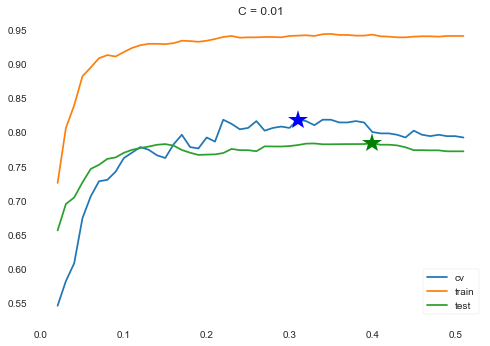

In [178]:
r = grid_results_df[grid_results_df["param_lr__C"] == C].sort_values(by=["param_countvec__max_df"])
plt.plot(r["param_countvec__max_df"], r["mean_test_score"], label="cv")
plt.plot(r["param_countvec__max_df"], r["mean_train_score"], label="train")
best_param_cv = r.sort_values(by=["rank_test_score"]).iloc[0]["param_countvec__max_df"]
best_val_cv = r.sort_values(by=["rank_test_score"]).iloc[0]["mean_test_score"]
plt.plot(best_param_cv, best_val_cv, 'b*', markersize=20)

plt.plot(param_grid["countvec__max_df"], scores, label="test")
best_param_test = param_grid["countvec__max_df"][np.argmax(scores)]
best_val_test = np.max(scores)
plt.plot(best_param_test, best_val_test, 'g*', markersize=20)
plt.legend();
plt.title("C = %s" % C);

What we can see here is that:

- The cross-validation scores are too optimistic
- The cross-validation score curve is very bumpy, due to the smaller data set
- The best values of `max_df` are different if you look at cv vs. test
- **Thus, not only can we not trust the cv scores, we also cannot trust cv's ability to choose of the best hypers**
  - But we don't have a lot of better alternatives, unfortunately, if we have a small dataset
  
![](img/mike_itiswhatitis.png)

#### The size of your dataset

- So, a very important factor here is **how much data you have**.
- With infinite amounts of training data, **overfitting would not be a problem** and you could have your test score = your train score.
  - This is a subtle point that takes time to digest.
  - But think of it this way: overfitting happens because you only see a bit of data and you learn patterns that are overly specific to your sample.
  - If you saw "all" the data, then the notion of "overly specific" would not apply.
- So, more data will make your test score better.
- But furthermore, it will make your _score estimates_ less noisy.
- Remember, `train_test_split` is a random split.
- What if you split differently?
  - **You don't want all your insights to be specific to your split - be careful!**

What to do if your test score is much lower than your cross-validation score:

- For one thing, you can more realistically report this to others.
- You can try a few different things, use the test set a couple of times, it's not the end of the world.
- I suggest trying simpler models, being conservative when communicating.

## Q&A

(Pause for Q&A)

<br><br><br><br>

## This week's dataset: income prediction from adult census data (15 min)


- We will use a classic dataset from the UCI dataset repository.
  - This one is about predicting income from adult census data.
  - You can download the dataset [here](https://www.kaggle.com/uciml/adult-census-income).
  - To run the code, you will need to download it and put it in the `data` folder.

In [16]:
census = pd.read_csv('data/adult.csv')
census_train, census_test = train_test_split(census, test_size=0.2, random_state=123)

#### Exploratory data analysis (EDA)

In [17]:
census_train.head()

age     workclass  fnlwgt     education  education.num  \
17064   20       Private  110998  Some-college             10   
18434   22       Private  263670       HS-grad              9   
3294    51       Private  335997       HS-grad              9   
31317   53       Private  111939     Bachelors             13   
4770    52  Self-emp-inc   51048     Bachelors             13   

           marital.status       occupation relationship                race  \
17064       Never-married     Adm-clerical    Own-child  Asian-Pac-Islander   
18434       Never-married    Other-service    Own-child               Black   
3294   Married-civ-spouse  Exec-managerial      Husband               White   
31317  Married-civ-spouse    Other-service      Husband               White   
4770   Married-civ-spouse            Sales      Husband               White   

          sex  capital.gain  capital.loss  hours.per.week native.country  \
17064  Female             0             0              30  United-States   
18434    Male             0             0              80  United-States   
3294     Male          4386             0              55  United-States   
31317    Male             0             0              35  United-States   
4770     Male             0             0              55  United-States   

      income  
17064  <=50K  
18434  <=50K  
3294    >50K  
31317  <=50K  
4770   <=50K

Note: many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary.

In [18]:
census_train.shape

(26048, 15)

In [19]:
census_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [20]:
census_train.describe()

age        fnlwgt  education.num  capital.gain  capital.loss  \
count  26048.000000  2.604800e+04   26048.000000  26048.000000  26048.000000   
mean      38.586686  1.892295e+05      10.070485   1075.695754     87.629991   
std       13.619181  1.050005e+05       2.572231   7334.297499    404.192112   
min       17.000000  1.376900e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175830e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.777850e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.368852e+05      12.000000      0.000000      0.000000   
max       90.000000  1.366120e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    26048.000000  
mean        40.433239  
std         12.346313  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

Let's explore the target value - this is often useful!

In [21]:
census_train[["income"]].describe()

income
count   26048
unique      2
top     <=50K
freq    19810

In [23]:
census_train["income"].value_counts()

<=50K    19810
>50K      6238
Name: income, dtype: int64

In [22]:
dc = DummyClassifier(strategy='prior')
dc.fit(None, census_train["income"])
dc.score(None, census_train["income"])

0.7605190417690417

- `DummyClassifier` does not involve X values, therefore X=None here in the code

So, 76% is a baseline score to beat.

- `pandas_profiling` is a fancy tool for EDA
- The term "profiling" is a bit unfortunate - this has nothing to do with timing code execution.

In [24]:
from pandas_profiling import ProfileReport

In [25]:
profile = ProfileReport(census_train, title='Pandas Profiling Report') #, minimal=True)

In [ ]:
# profile.to_file('profile_report.html')

This next line can take a while...

In [26]:
profile.to_notebook_iframe();

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Break (5 min)

<br><br><br><br>

## Encoding of categorical variables (25 mins)

- Let's try to build a `LogisticRegression` classifier on this data?
- This will fail because we have non-numeric data.

In [27]:
X_train_census = census_train.drop(columns=["income"])
y_train_census = census_train["income"]

In [28]:
lr = LogisticRegression()
lr.fit(X_train_census, y_train_census)

ValueError: could not convert string to float: 'United-States'

- This is the same issue with had with raw text last time.
- We are not supposed to use `countVectorizer` here since we are not looking for keywords in a bunch of free text. The X's are actually categorical variables.
- We need to preprocess the data into numeric values. 

In [29]:
census_train.head()

age     workclass  fnlwgt     education  education.num  \
17064   20       Private  110998  Some-college             10   
18434   22       Private  263670       HS-grad              9   
3294    51       Private  335997       HS-grad              9   
31317   53       Private  111939     Bachelors             13   
4770    52  Self-emp-inc   51048     Bachelors             13   

           marital.status       occupation relationship                race  \
17064       Never-married     Adm-clerical    Own-child  Asian-Pac-Islander   
18434       Never-married    Other-service    Own-child               Black   
3294   Married-civ-spouse  Exec-managerial      Husband               White   
31317  Married-civ-spouse    Other-service      Husband               White   
4770   Married-civ-spouse            Sales      Husband               White   

          sex  capital.gain  capital.loss  hours.per.week native.country  \
17064  Female             0             0              30  United-States   
18434    Male             0             0              80  United-States   
3294     Male          4386             0              55  United-States   
31317    Male             0             0              35  United-States   
4770     Male             0             0              55  United-States   

      income  
17064  <=50K  
18434  <=50K  
3294    >50K  
31317  <=50K  
4770   <=50K

In [31]:
census_train['workclass'].value_counts()

Private             18168
Self-emp-not-inc     2044
Local-gov            1689
?                    1448
State-gov            1045
Self-emp-inc          878
Federal-gov           760
Without-pay            11
Never-worked            5
Name: workclass, dtype: int64

In [32]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'education', 'marital.status', 
                        'occupation', 'relationship', 'race', 
                        'sex', 'native.country']
target_columns = 'income'

#### No encoding (not recommended!)

- For starters, let's just delete the categorical features.

In [33]:
census_train_numeric = X_train_census.drop(columns=categorical_features)
census_train_numeric.head()

age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week
17064   20  110998             10             0             0              30
18434   22  263670              9             0             0              80
3294    51  335997              9          4386             0              55
31317   53  111939             13             0             0              35
4770    52   51048             13             0             0              55

In [34]:
lr = LogisticRegression()
lr.fit(census_train_numeric, y_train_census);

Now the code runs, but we discarded so much information!

#### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [35]:
from sklearn.preprocessing import OrdinalEncoder

In [36]:
oe = OrdinalEncoder(dtype=int)

BTW this is a transformer object just like `CountVectorizer`.

In [37]:
transformed = oe.fit_transform(X_train_census[categorical_features])
transformed

array([[ 4, 15,  4, ...,  1,  0, 39],
       [ 4, 11,  4, ...,  2,  1, 39],
       [ 4, 11,  2, ...,  4,  1, 39],
       ...,
       [ 4, 15,  2, ...,  4,  0, 39],
       [ 4,  4,  4, ...,  4,  1,  4],
       [ 4, 11,  0, ...,  4,  0, 39]])

In [38]:
transformed = pd.DataFrame(data=transformed, columns=categorical_features, index=X_train_census.index)
transformed

workclass  education  marital.status  occupation  relationship  race  \
17064          4         15               4           1             3     1   
18434          4         11               4           8             3     2   
3294           4         11               2           4             0     4   
31317          4          9               2           8             0     4   
4770           5          9               2          12             0     4   
...          ...        ...             ...         ...           ...   ...   
28636          4         11               2           7             5     4   
17730          4          0               4           8             4     2   
28030          4         15               2           1             5     4   
15725          4          4               4           3             1     4   
19966          4         11               0           6             1     4   

       sex  native.country  
17064    0              39  
18434    1              39  
3294     1              39  
31317    1              39  
4770     1              39  
...    ...             ...  
28636    0              39  
17730    0              39  
28030    0              39  
15725    1               4  
19966    0              39  

[26048 rows x 8 columns]

We can see the mapping from strings to integers here:

In [39]:
oe.categories_

[array(['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private',
        'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'],
       dtype=object),
 array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
        'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
        'Masters', 'Preschool', 'Prof-school', 'Some-college'],
       dtype=object),
 array(['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
        'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'],
       dtype=object),
 array(['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair',
        'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners',
        'Machine-op-inspct', 'Other-service', 'Priv-house-serv',
        'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support',
        'Transport-moving'], dtype=object),
 array(['Husband', 'Not-in-family', 'Other-relative', 'Own-child',
        'Unmarried', 'Wife'], dtype=object),
 array(['Amer-Indian-Eskimo'

(Note: we'll deal with the `?` cases next class)

Now, we can smush this back into the original array:

In [40]:
census_train_ord = pd.concat((X_train_census.drop(columns=categorical_features), transformed), axis=1)
census_train_ord

age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week  \
17064   20  110998             10             0             0              30   
18434   22  263670              9             0             0              80   
3294    51  335997              9          4386             0              55   
31317   53  111939             13             0             0              35   
4770    52   51048             13             0             0              55   
...    ...     ...            ...           ...           ...             ...   
28636   48   70668              9             0             0              50   
17730   35  340018              6             0             0              38   
28030   26  373553             10             0             0              42   
15725   28  155621              3             0             0              40   
19966   40  151294              9             0             0              48   

       workclass  education  marital.status  occupation  relationship  race  \
17064          4         15               4           1             3     1   
18434          4         11               4           8             3     2   
3294           4         11               2           4             0     4   
31317          4          9               2           8             0     4   
4770           5          9               2          12             0     4   
...          ...        ...             ...         ...           ...   ...   
28636          4         11               2           7             5     4   
17730          4          0               4           8             4     2   
28030          4         15               2           1             5     4   
15725          4          4               4           3             1     4   
19966          4         11               0           6             1     4   

       sex  native.country  
17064    0              39  
18434    1              39  
3294     1              39  
31317    1              39  
4770     1              39  
...    ...             ...  
28636    0              39  
17730    0              39  
28030    0              39  
15725    1               4  
19966    0              39  

[26048 rows x 14 columns]

- `concat` takes the first five columns from before (with only the numerical variables) and merges with the transformed categorical variables

Bam! Now we have all the features together and all numeric.

In [41]:
lr = LogisticRegression()
lr.fit(census_train_ord, y_train_census);

- Can you see a big problem with this approach?
  - We have imposed ordinality on the categorical data.
  - The categorical variable we transformed are not ordered. What we have done here is just imposing(强加) order on something that is unordered. It doesn't make any sense.

In [42]:
pd.DataFrame(index=oe.categories_[-1], data=np.arange(len(oe.categories_[-1])), columns=["transformed"]).head(10)

transformed
?                             0
Cambodia                      1
Canada                        2
China                         3
Columbia                      4
Cuba                          5
Dominican-Republic            6
Ecuador                       7
El-Salvador                   8
England                       9

- For example, logistic regression will learn a coefficient. 
- If that coefficient is positive, it means that as you go down the list you'll be more likely to predict high income.
- But why would alphabetic order be significant at all? And besides, the order is completely arbitrary.

## Q&A

(Pause for Q&A)

<br><br><br><br>

#### One-hot encoding (OHE)
- Rather than assign integer labels to our data, we use create new binary columns to represent our categories.
- Before, one original column became one transformed column.
- But remember `CountVectorizer` - one piece of text became _many_ transformed columns.
- The same will be true here. We'll make **one transformed column per category**.
- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
ohe = OneHotEncoder(sparse=False, dtype='int')

In [45]:
transformed_ohe = ohe.fit_transform(X_train_census[categorical_features])
transformed_ohe

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

We put a "1" for the actual value and "0" otherwise.


In [46]:
transformed_ohe = pd.DataFrame(data=transformed_ohe, columns=ohe.get_feature_names(categorical_features), index=X_train_census.index)
transformed_ohe.head()

workclass_?  workclass_Federal-gov  workclass_Local-gov  \
17064            0                      0                    0   
18434            0                      0                    0   
3294             0                      0                    0   
31317            0                      0                    0   
4770             0                      0                    0   

       workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
17064                       0                  1                       0   
18434                       0                  1                       0   
3294                        0                  1                       0   
31317                       0                  1                       0   
4770                        0                  0                       1   

       workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  \
17064                           0                    0                      0   
18434                           0                    0                      0   
3294                            0                    0                      0   
31317                           0                    0                      0   
4770                            0                    0                      0   

       education_10th  ...  native.country_Portugal  \
17064               0  ...                        0   
18434               0  ...                        0   
3294                0  ...                        0   
31317               0  ...                        0   
4770                0  ...                        0   

       native.country_Puerto-Rico  native.country_Scotland  \
17064                           0                        0   
18434                           0                        0   
3294                            0                        0   
31317                           0                        0   
4770                            0                        0   

       native.country_South  native.country_Taiwan  native.country_Thailand  \
17064                     0                      0                        0   
18434                     0                      0                        0   
3294                      0                      0                        0   
31317                     0                      0                        0   
4770                      0                      0                        0   

       native.country_Trinadad&Tobago  native.country_United-States  \
17064                               0                             1   
18434                               0                             1   
3294                                0                             1   
31317                               0                             1   
4770                                0                             1   

       native.country_Vietnam  native.country_Yugoslavia  
17064                       0                          0  
18434                       0                          0  
3294                        0                          0  
31317                       0                          0  
4770                        0                          0  

[5 rows x 102 columns]

Here we see the 9 columns for the categorical feature `workclass` with 9 possible values.

In [47]:
census_train_ohe = pd.concat((X_train_census.drop(columns=categorical_features), transformed_ohe), axis=1)
census_train_ohe

age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week  \
17064   20  110998             10             0             0              30   
18434   22  263670              9             0             0              80   
3294    51  335997              9          4386             0              55   
31317   53  111939             13             0             0              35   
4770    52   51048             13             0             0              55   
...    ...     ...            ...           ...           ...             ...   
28636   48   70668              9             0             0              50   
17730   35  340018              6             0             0              38   
28030   26  373553             10             0             0              42   
15725   28  155621              3             0             0              40   
19966   40  151294              9             0             0              48   

       workclass_?  workclass_Federal-gov  workclass_Local-gov  \
17064            0                      0                    0   
18434            0                      0                    0   
3294             0                      0                    0   
31317            0                      0                    0   
4770             0                      0                    0   
...            ...                    ...                  ...   
28636            0                      0                    0   
17730            0                      0                    0   
28030            0                      0                    0   
15725            0                      0                    0   
19966            0                      0                    0   

       workclass_Never-worked  ...  native.country_Portugal  \
17064                       0  ...                        0   
18434                       0  ...                        0   
3294                        0  ...                        0   
31317                       0  ...                        0   
4770                        0  ...                        0   
...                       ...  ...                      ...   
28636                       0  ...                        0   
17730                       0  ...                        0   
28030                       0  ...                        0   
15725                       0  ...                        0   
19966                       0  ...                        0   

       native.country_Puerto-Rico  native.country_Scotland  \
17064                           0                        0   
18434                           0                        0   
3294                            0                        0   
31317                           0                        0   
4770                            0                        0   
...                           ...                      ...   
28636                           0                        0   
17730                           0                        0   
28030                           0                        0   
15725                           0                        0   
19966                           0                        0   

       native.country_South  native.country_Taiwan  native.country_Thailand  \
17064                     0                      0                        0   
18434                     0                      0                        0   
3294                      0                      0                        0   
31317                     0                      0                        0   
4770                      0                      0                        0   
...                     ...                    ...                      ...   
28636                     0                      0                        0   
17730                     0                      0                        0   
28030                     0 

In [48]:
len(categorical_features)

8

In [49]:
lr = LogisticRegression()
lr.fit(census_train_ohe, y_train_census);

#### Categorical labels (target values)

- For now sklearn is fine with categorical labels (y-values), so we're not preprocessing them.
- sklearn cannot deal with categorical Xs, but it is fine with categorical y. So we only need to transform those Xs into numerical values.


In [50]:
y_train_census.head()

17064    <=50K
18434    <=50K
3294      >50K
31317    <=50K
4770     <=50K
Name: income, dtype: object

#### Side note: 

- Theoretically, decision trees should have no problem with categorical inputs
  - e.g., "is the treatment equal to C?"
  - However, the sklearn implementation does not support this, so we need to convert the features to numerical.
- On the other hand, logistic regression fundamentally operates on numerical data
  - So any implementation would require these transformations.

#### Some more notes on OHE vs. Ordinal, from Piazza last year

When you have a discrete, ordered feature (such as the [cold, warm, hot] example), the numerical value associated with a given feature example (i.e. cold=0, warm=1, hot=2) has meaning beyond just being a label. If this was a feature being used to classify drinks as iced tea or hot chocolate, the model would learn that the higher the value of this feature is for a given example, the more likely it is that the drink is a hot chocolate. The weights it learns would reflect this; the weight associated with this feature would be set such that larger values for the feature would result in a larger probability or score for the label hot chocolate. Note that here I am assuming we are using a model that learns weights (such as linear regression or SVMs) rather than a decision tree, but the logic holds regardless.

In another feature where there is no ordering (say container = [paper cup, glass, mug]), if we gave values to the categories in the same way (paper cup = 0, glass = 1, mug = 2) the model would try to learn weights in the same way, looking for a correlation between the magnitude of the value of the feature and the correct label. Except here there isn't this type of correlation; values of 0 or 2 are more likely for hot chocolate and 1 is more likely for iced tea. By assigning numerical values to the categories we have imposed an ordering where there isn't one, and the model's only options are to conclude that the feature isn't useful and assign it a very small weight, or to try and find a correlation where there isn't one. Either case is bad; if the model concludes the feature isn't useful we are wasting information since the feature really does contain relevant information, and if it tries to find a pattern it is likely to overfit since it is assigning meaning to the numerical values where a meaning doesn't exist. Using a one hot encoding fixes these issues since we don't impose any false ordering on the data but all of the information is still provided to the model.

## Q&A

(Pause for Q&A)

<br><br><br><br>

#### Back to ordinal encoding

- Q: If ordinal encoding is a bad idea, why does scikit-learn offer it?
- A: it is sometimes a good idea!
- Let's take another look at our data:

In [51]:
census_train.head()

age     workclass  fnlwgt     education  education.num  \
17064   20       Private  110998  Some-college             10   
18434   22       Private  263670       HS-grad              9   
3294    51       Private  335997       HS-grad              9   
31317   53       Private  111939     Bachelors             13   
4770    52  Self-emp-inc   51048     Bachelors             13   

           marital.status       occupation relationship                race  \
17064       Never-married     Adm-clerical    Own-child  Asian-Pac-Islander   
18434       Never-married    Other-service    Own-child               Black   
3294   Married-civ-spouse  Exec-managerial      Husband               White   
31317  Married-civ-spouse    Other-service      Husband               White   
4770   Married-civ-spouse            Sales      Husband               White   

          sex  capital.gain  capital.loss  hours.per.week native.country  \
17064  Female             0             0              30  United-States   
18434    Male             0             0              80  United-States   
3294     Male          4386             0              55  United-States   
31317    Male             0             0              35  United-States   
4770     Male             0             0              55  United-States   

      income  
17064  <=50K  
18434  <=50K  
3294    >50K  
31317  <=50K  
4770   <=50K

In [52]:
categorical_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [53]:
census_train[categorical_features]

workclass     education      marital.status         occupation  \
17064       Private  Some-college       Never-married       Adm-clerical   
18434       Private       HS-grad       Never-married      Other-service   
3294        Private       HS-grad  Married-civ-spouse    Exec-managerial   
31317       Private     Bachelors  Married-civ-spouse      Other-service   
4770   Self-emp-inc     Bachelors  Married-civ-spouse              Sales   
...             ...           ...                 ...                ...   
28636       Private       HS-grad  Married-civ-spouse  Machine-op-inspct   
17730       Private          10th       Never-married      Other-service   
28030       Private  Some-college  Married-civ-spouse       Adm-clerical   
15725       Private       5th-6th       Never-married       Craft-repair   
19966       Private       HS-grad            Divorced  Handlers-cleaners   

        relationship                race     sex native.country  
17064      Own-child  Asian-Pac-Islander  Female  United-States  
18434      Own-child               Black    Male  United-States  
3294         Husband               White    Male  United-States  
31317        Husband               White    Male  United-States  
4770         Husband               White    Male  United-States  
...              ...                 ...     ...            ...  
28636           Wife               White  Female  United-States  
17730      Unmarried               Black  Female  United-States  
28030           Wife               White  Female  United-States  
15725  Not-in-family               White    Male       Columbia  
19966  Not-in-family               White  Female  United-States  

[26048 rows x 8 columns]

- Some of the categorical features are truly categorical, meaning un-ordered categories. 
- But what about `education` - here we do actually have an order!

In [54]:
census_train["education"].unique()

array(['Some-college', 'HS-grad', 'Bachelors', 'Doctorate', '12th',
       '10th', 'Masters', '11th', 'Prof-school', 'Assoc-voc',
       'Assoc-acdm', '7th-8th', '9th', '1st-4th', 'Preschool', '5th-6th'],
      dtype=object)

I would put these in order:

In [55]:
education_levels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', 
                    '9th', '10th', '11th', '12th', 'HS-grad',
                    'Prof-school', 'Assoc-voc', 'Assoc-acdm', 
                    'Some-college', 'Bachelors', 'Masters', 'Doctorate']

In [58]:
education_levels[::-1]

['Doctorate',
 'Masters',
 'Bachelors',
 'Some-college',
 'Assoc-acdm',
 'Assoc-voc',
 'Prof-school',
 'HS-grad',
 '12th',
 '11th',
 '10th',
 '9th',
 '7th-8th',
 '5th-6th',
 '1st-4th',
 'Preschool']

Make sure we didn't miss anything:

In [56]:
assert set(education_levels) == set(census_train["education"].unique())

Now we can redo the ordinal encoding:

In [57]:
oe = OrdinalEncoder(categories=[education_levels], dtype=int)

transformed = oe.fit_transform(X_train_census[["education"]])
transformed = pd.DataFrame(data=transformed, columns=["education_int"], index=X_train_census.index)
pd.concat((X_train_census[["education"]], transformed), axis=1)

education  education_int
17064  Some-college             12
18434       HS-grad              8
3294        HS-grad              8
31317     Bachelors             13
4770      Bachelors             13
...             ...            ...
28636       HS-grad              8
17730          10th              5
28030  Some-college             12
15725       5th-6th              2
19966       HS-grad              8

[26048 rows x 2 columns]

- Now it makes perfect sense! 
- E.g. if logistic regression learns a positive coefficient, that means higher education corresponds to higher income. 
- Whereas with OHE it would just learn a separate coefficient for each category.
  - It would learn bigger coefficients for bigger education levels.
- That might be OK if you had infinite date, but we have limited training data from which to learn patterns.
  - **Preprocessing your data properly is a way to inject human domain knowledge.**
  - The less data you have, the more important this is.

So what we want is:

In [59]:
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 
                    'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 
                        'relationship', 'race', 'sex', 'native.country']
ordinal_features = ['education']
target_column = 'income'

- It doesn't matter if you gonna treat a variable with only 2 different values as a categorical data or ordinal data. It does matter when the variable has more than 2 different values.

- We'll continue with this next class.
- For today, we'll dig deeper into OHE.

## Q&A

(Pause for Q&A)

<br><br><br><br>

## OHE deep dive (15 min)

- We haven't yet scored our model, let's try that now.
- For now, to keep it simple, we'll just use the categorical features only.
- Next class we'll put everything together with some new sklearn syntax.

In [60]:
X_train = census_train[categorical_features]
y_train = census_train[target_column]

In [61]:
pipe = Pipeline([('ohe', OneHotEncoder()),
                 ('lr', LogisticRegression(max_iter=1000))])

In [62]:
pipe.fit(X_train, y_train);

In [63]:
pipe.score(X_train, y_train)

0.8214834152334153

In [64]:
cross_validate(pipe, X_train, y_train)

ValueError: Found unknown categories ['Holand-Netherlands'] in column 6 during transform

- What is going on here??
- Let's look at the error message:

> Found unknown categories ['Holand-Netherlands'] in column 6 during transform

Hint:

In [65]:
X_train["native.country"].value_counts()

United-States                 23338
Mexico                          532
?                               475
Philippines                     146
Germany                         108
Canada                           92
Puerto-Rico                      88
El-Salvador                      87
India                            86
Cuba                             74
Jamaica                          69
England                          69
South                            64
Dominican-Republic               56
China                            54
Japan                            52
Poland                           52
Vietnam                          52
Guatemala                        50
Italy                            49
Columbia                         40
Taiwan                           40
Iran                             37
Haiti                            34
Nicaragua                        31
Portugal                         31
Ecuador                          26
Peru                        

Any ideas?

<br><br><br><br>

Answer:

- There is only one instance of Holand-Netherlands.
- This is getting put into the validation split. 
- This error appears when some X sets only show in validation set. (we only `fit` the train set, so the system does not know any information about unfit set.
- Let's look at the OHE:

In [66]:
transformed_ohe

workclass_?  workclass_Federal-gov  workclass_Local-gov  \
17064            0                      0                    0   
18434            0                      0                    0   
3294             0                      0                    0   
31317            0                      0                    0   
4770             0                      0                    0   
...            ...                    ...                  ...   
28636            0                      0                    0   
17730            0                      0                    0   
28030            0                      0                    0   
15725            0                      0                    0   
19966            0                      0                    0   

       workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  \
17064                       0                  1                       0   
18434                       0                  1                       0   
3294                        0                  1                       0   
31317                       0                  1                       0   
4770                        0                  0                       1   
...                       ...                ...                     ...   
28636                       0                  1                       0   
17730                       0                  1                       0   
28030                       0                  1                       0   
15725                       0                  1                       0   
19966                       0                  1                       0   

       workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  \
17064                           0                    0                      0   
18434                           0                    0                      0   
3294                            0                    0                      0   
31317                           0                    0                      0   
4770                            0                    0                      0   
...                           ...                  ...                    ...   
28636                           0                    0                      0   
17730                           0                    0                      0   
28030                           0                    0                      0   
15725                           0                    0                      0   
19966                           0                    0                      0   

       education_10th  ...  native.country_Portugal  \
17064               0  ...                        0   
18434               0  ...                        0   
3294                0  ...                        0   
31317               0  ...                        0   
4770                0  ...                        0   
...               ...  ...                      ...   
28636               0  ...                        0   
17730               1  ...                        0   
28030               0  ...                        0   
15725               0  ...                        0   
19966               0  ...                        0   

       native.country_Puerto-Rico  native.country_Scotland  \
17064                           0                        0   
18434                           0                        0   
3294                            0                        0   
31317                           0                        0   
4770                            0                        0   
...                           ...                      ...   
28636                           0                        0   
17730                           0                        0   
28030                           0                        0   
15725                           0              

- We make a column for each country, but then when testing we hit a country we've never seen.
- This is analogous to what we saw last week with `CountVectorizer` if you have a word that only appears in the validation/test set.
- By default, `CountVectorizer` just ignores this (because many words get ignored in general).
- By default, `OneHotEncoder` throws an error because you might want to know about this.

Simplest fix:

In [67]:
pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')), # <-- see this argument
                 ('lr', LogisticRegression(max_iter=1000))])

- "handle_unknown='ignore'" basically means that if you have an unknown category when calling `transform`, don't through an error, just put 0's everywhere to that person/in that row (Normally, a row will be a 1 somewhere and 0's anywhere else)

In [68]:
cross_validate(pipe, X_train, y_train)

{'fit_time': array([0.3878808 , 0.31932187, 0.32660007, 0.36998296, 0.33769083]),
 'score_time': array([0.01784897, 0.01467204, 0.01418066, 0.01412201, 0.01461625]),
 'test_score': array([0.81996161, 0.81708253, 0.81477927, 0.82818199, 0.82319063])}

- Now it works. 
- How does it transform this unknown value? By putting a 0 in all the columns. 
- Important question: do we **want** this behaviour?

<br><br><br><br>

- Answer: it depends. 
- The row of all 0s is sort of like an "other" category. 
- In that case, "Holland" or "Mars" or "Hogwarts" would all be treated the same.
- Important question to ask yourself: **could you get unseen values of a category during deployment?**
  - E.g. if the categories are provinces/territories of Canada, we know the possible values and we can just specify them in when doing `fit`.
- If we know the categories, this might be a reasonable time to "violate the Golden Rule" (look at the test set) and just hard-code all the categories:

In [69]:
all_countries = census["native.country"].unique()
all_countries

array(['United-States', '?', 'Mexico', 'Greece', 'Vietnam', 'China',
       'Taiwan', 'India', 'Philippines', 'Trinadad&Tobago', 'Canada',
       'South', 'Holand-Netherlands', 'Puerto-Rico', 'Poland', 'Iran',
       'England', 'Germany', 'Italy', 'Japan', 'Hong', 'Honduras', 'Cuba',
       'Ireland', 'Cambodia', 'Peru', 'Nicaragua', 'Dominican-Republic',
       'Haiti', 'El-Salvador', 'Hungary', 'Columbia', 'Guatemala',
       'Jamaica', 'Ecuador', 'France', 'Yugoslavia', 'Scotland',
       'Portugal', 'Laos', 'Thailand', 'Outlying-US(Guam-USVI-etc)'],
      dtype=object)

In [70]:
ohe_cat = OneHotEncoder(categories=all_countries)

- This syntax allows you to pre-define the categories.
- It's a little more complicated if you only want to do this for _some_ of the categorical variables.
- Next class we'll talk about a tool to make that easier.

#### OHE and the Golden Rule

- Going back to our discussion of the Golden Rule last time, the same ideas apply here as with `CountVectorizer` (in fact they are quite similar)
- E.g. if you are pre-setting the categories, then there is no "leakage" issue, but by default there is because it looks through everywhere.

#### Dropping a column

There is another popular argument in `OneHotEncoder` as follows:

In [71]:
ohe_def = OneHotEncoder(sparse=False, dtype=int)
ohe_def.fit(X_train_census[["relationship"]])
pd.DataFrame(data=ohe_def.transform(X_train_census[["relationship"]]), columns=ohe_def.get_feature_names(["relationship"]), index=X_train_census.index)

relationship_Husband  relationship_Not-in-family  \
17064                     0                           0   
18434                     0                           0   
3294                      1                           0   
31317                     1                           0   
4770                      1                           0   
...                     ...                         ...   
28636                     0                           0   
17730                     0                           0   
28030                     0                           0   
15725                     0                           1   
19966                     0                           1   

       relationship_Other-relative  relationship_Own-child  \
17064                            0                       1   
18434                            0                       1   
3294                             0                       0   
31317                            0                       0   
4770                             0                       0   
...                            ...                     ...   
28636                            0                       0   
17730                            0                       0   
28030                            0                       0   
15725                            0                       0   
19966                            0                       0   

       relationship_Unmarried  relationship_Wife  
17064                       0                  0  
18434                       0                  0  
3294                        0                  0  
31317                       0                  0  
4770                        0                  0  
...                       ...                ...  
28636                       0                  1  
17730                       1                  0  
28030                       0                  1  
15725                       0                  0  
19966                       0                  0  

[26048 rows x 6 columns]

In [72]:
ohe_drop = OneHotEncoder(sparse=False, dtype=int, drop='first') # <-- see this argument

- "drop='first'" throughs away the first column

In [73]:
ohe_drop.fit(X_train_census[["relationship"]])
ohe_drop_df = pd.DataFrame(data=ohe_drop.transform(X_train_census[["relationship"]]), columns=ohe_drop.get_feature_names(["relationship"]), index=X_train_census.index)
ohe_drop_df

relationship_Not-in-family  relationship_Other-relative  \
17064                           0                            0   
18434                           0                            0   
3294                            0                            0   
31317                           0                            0   
4770                            0                            0   
...                           ...                          ...   
28636                           0                            0   
17730                           0                            0   
28030                           0                            0   
15725                           1                            0   
19966                           1                            0   

       relationship_Own-child  relationship_Unmarried  relationship_Wife  
17064                       1                       0                  0  
18434                       1                       0                  0  
3294                        0                       0                  0  
31317                       0                       0                  0  
4770                        0                       0                  0  
...                       ...                     ...                ...  
28636                       0                       0                  1  
17730                       0                       1                  0  
28030                       0                       0                  1  
15725                       0                       0                  0  
19966                       0                       0                  0  

[26048 rows x 5 columns]

- Notice that the "husband" column is missing here.
- Look at the 3rd row:

In [74]:
ohe_drop_df.iloc[3:4]

relationship_Not-in-family  relationship_Other-relative  \
31317                           0                            0   

       relationship_Own-child  relationship_Unmarried  relationship_Wife  
31317                       0                       0                  0

- This was a husband case, and it got mapped to all zeros.
- So, this process is still "invertible"(可逆的) because you can recover the original category.
- The choice of first is arbitrary, it makes no difference.


**Overall, I do not recommend using `drop='first'` in almost any situation.**

Pros:

- In certain cases, like `LinearRegression` (which I will recommend you never use), this is really important.
- It is technically redundant to not do this.

Cons:

- It prevents you from doing `handle_unknown='ignore'` which is very often useful. Because both of them try to use 0's to mean something.
- It makes the interpretation of feature importances more confusing (see a later lecture).
- Occasionally the choice of which feature gets dropped does actually matter, e.g. feature selection after OHE (see a later lecture).

But I wanted you to know about it because it's fairly common.

## Q&A

(Pause for Q&A)

<br><br><br><br>

#### Categorical features with many categories

- We saw in the previous class and hw3 that including more words with `CountVectorizer` is consider a more complex model (less underfitting, more overfitting).
- This is likewise true with lots of categories in OHE. 
- Let's return to the countries:

In [75]:
X_train["native.country"].value_counts()

United-States                 23338
Mexico                          532
?                               475
Philippines                     146
Germany                         108
Canada                           92
Puerto-Rico                      88
El-Salvador                      87
India                            86
Cuba                             74
Jamaica                          69
England                          69
South                            64
Dominican-Republic               56
China                            54
Japan                            52
Poland                           52
Vietnam                          52
Guatemala                        50
Italy                            49
Columbia                         40
Taiwan                           40
Iran                             37
Haiti                            34
Nicaragua                        31
Portugal                         31
Ecuador                          26
Peru                        

- This may be too detailed, and the amount of data is very limited for most of these countries. Can you really learn from 11 examples?

Some possible solutions:

- Group into bigger categories, e.g "Europe", "Asia", etc. 
- This can basically be considered a hyperparameter - that is, you can search over possible approaches and see what works best.
- Have an "other" category for rare cases:

In [76]:
most_common_countries = X_train["native.country"].value_counts().iloc[:5]
most_common_countries

United-States    23338
Mexico             532
?                  475
Philippines        146
Germany            108
Name: native.country, dtype: int64

These are the most common cases.

In [77]:
ohe = OneHotEncoder(sparse=False, dtype=int, handle_unknown='ignore', 
                    categories=[most_common_countries.index.values])

In [78]:
ohe.fit(X_train_census[["native.country"]])
ohe_df = pd.DataFrame(data=ohe.transform(X_train_census[["native.country"]]), columns=ohe.get_feature_names(["native_country"]), index=X_train_census.index)
ohe_df

native_country_United-States  native_country_Mexico  native_country_?  \
17064                             1                      0                 0   
18434                             1                      0                 0   
3294                              1                      0                 0   
31317                             1                      0                 0   
4770                              1                      0                 0   
...                             ...                    ...               ...   
28636                             1                      0                 0   
17730                             1                      0                 0   
28030                             1                      0                 0   
15725                             0                      0                 0   
19966                             1                      0                 0   

       native_country_Philippines  native_country_Germany  
17064                           0                       0  
18434                           0                       0  
3294                            0                       0  
31317                           0                       0  
4770                            0                       0  
...                           ...                     ...  
28636                           0                       0  
17730                           0                       0  
28030                           0                       0  
15725                           0                       0  
19966                           0                       0  

[26048 rows x 5 columns]

- Here, anything else becomes an "other" which is represented by all zeros. 
- I don't think there's a need to create an explicit "other" column, unless you want to distinguish between "everything else" vs. "unseen value".

#### Binary features

- In this dataset the only binary feature (coded with two possible values in the dataset) is sex.
- Let's try OHE on that feature:

In [79]:
ohe = OneHotEncoder(sparse=False, dtype=int)
ohe.fit(X_train_census[["sex"]])
ohe_df = pd.DataFrame(data=ohe.transform(X_train_census[["sex"]]), columns=ohe.get_feature_names(["sex"]), index=X_train_census.index)
ohe_df

sex_Female  sex_Male
17064           1         0
18434           0         1
3294            0         1
31317           0         1
4770            0         1
...           ...       ...
28636           1         0
17730           1         0
28030           1         0
15725           0         1
19966           1         0

[26048 rows x 2 columns]

- This is an extreme version where it seems particularly unnecessary to have two separate columns.
- Think about the words in `CountVectorizer`: imagine have a column for "amazing" in review and another for "amazing" not in review.
- So, for this case in particular, we can use another value of the `drop` parameter:

In [80]:
ohe = OneHotEncoder(sparse=False, dtype=int, drop="if_binary") # <-- see here
ohe.fit(X_train_census[["sex"]])
ohe_df = pd.DataFrame(data=ohe.transform(X_train_census[["sex"]]), columns=ohe.get_feature_names(["sex"]), index=X_train_census.index)
ohe_df

sex_Male
17064         0
18434         1
3294          1
31317         1
4770          1
...         ...
28636         0
17730         0
28030         0
15725         1
19966         0

[26048 rows x 1 columns]

- "drop="if_binary"" means that drop the (alphabetically) first one if it's a binary variable

- It arbitrarily chooses one of the two categories based on the sorting. 
- In that case alphabetically it was [Female, Male] and it drops the first one.
- As mentioned above I don't recommend `drop='first'` but I'm good with `drop='if_binary'`.
- However, `drop='if_binary'` does not work with `handle_unknown='ignore'` and so you may end up skipping it for convenience.
  - If I were going the extra mile about this I might do it manually, e.g. by specifying the categories for that variable, but I don't think it's a big deal.

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Summary

- Optimization bias, aka overfitting on the validation set is a problem especially when:
  - The validation set is small
  - You use the validation set many times.
- The test set can be used as a final arbiter...
  - But even that is not trustworthy when it's small.
- Categorical variables can be encoded in several ways.
  - Ordered variables should use `OrdinalEncoder`
  - Categorical variables should use `OneHotEncoder`
- One-hot encoding (OHE) is fairly nuanced:
  - You may want to pre-set the categories
  - You may want an "other" category
  - You may want only one column for binary variables
  - I recommend avoiding `drop='first'`